In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re

import generate_data as gd

In [2]:
# resnet/whole_mm_indiv_data.py using 5 blocks

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])


In [4]:
# For the data generator all variables have to be merged into a single dataset.
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
}

# For the data generator all variables have to be merged into a single dataset.
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))


In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        #if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)        
            
bs=32
lead_time=72
output_vars = ['z_500', 't_850']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std,
                         shuffle=False, output_vars=output_vars)



In [7]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    print(i)
    X2, y2 = dg_test[i]
    X1 = np.concatenate((X1, X2))
    y1 = np.concatenate((y1, y2)) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
real_unnorm =y1* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [11]:
# read in outputs

temp_levels = xr.open_dataset('/rds/general/user/mc4117/ephemeral/saved_pred/temp_levels_5_preds.nc')
geo_levels = xr.open_dataset('/rds/general/user/mc4117/ephemeral/saved_pred/geo_levels_5_preds.nc')

sh = xr.open_dataset('/rds/general/user/mc4117/ephemeral/saved_pred/sh_5_preds.nc')
pv = xr.open_dataset('/rds/general/user/mc4117/ephemeral/saved_pred/pv_5_preds.nc')
const = xr.open_dataset('/rds/general/user/mc4117/ephemeral/saved_pred/const_5_preds.nc')

In [12]:
mean_t_z = [dg_test.mean.isel(level=dg_test.output_idxs).values[1], dg_test.mean.isel(level=dg_test.output_idxs).values[0]]
std_t_z = [dg_test.std.isel(level=dg_test.output_idxs).values[1], dg_test.std.isel(level=dg_test.output_idxs).values[0]]

mean_z_t = dg_test.mean.isel(level=dg_test.output_idxs).values
std_z_t = dg_test.std.isel(level=dg_test.output_idxs).values

In [13]:
temp_array = np.transpose(temp_levels.to_array().data, axes = [1, 2, 3, 0])
temp_array_rearrange = np.zeros(temp_array.shape)
temp_array_rearrange[:, :, :, 0] = temp_array[:, :, :, 1]
temp_array_rearrange[:, :, :, 1] = temp_array[:, :, :, 0] 

geo_array = np.transpose(geo_levels.to_array().data, axes = [1, 2, 3, 0])
geo_array_rearrange = np.zeros(geo_array.shape)
geo_array_rearrange[:, :, :, 0] = geo_array[:, :, :, 1]
geo_array_rearrange[:, :, :, 1] = geo_array[:, :, :, 0] 

const_array = np.transpose(const.to_array().data, axes = [1, 2, 3, 0])
const_array_rearrange = np.zeros(const_array.shape)
const_array_rearrange[:, :, :, 0] = const_array[:, :, :, 1]
const_array_rearrange[:, :, :, 1] = const_array[:, :, :, 0] 

In [15]:
temp_norm = (temp_array_rearrange - mean_z_t)/std_z_t
geo_norm = (geo_array_rearrange - mean_z_t)/std_z_t

sh_norm = (np.transpose(sh.to_array().data, axes = [1, 2, 3, 0])-mean_z_t)/std_z_t
pv_norm = (np.transpose(pv.to_array().data, axes = [1, 2, 3, 0])-mean_z_t)/std_z_t
const_norm = (const_array_rearrange-mean_z_t)/std_z_t

In [16]:
stack_test_list = [temp_norm, geo_norm, sh_norm, pv_norm, const_norm]

In [17]:
from tensorflow.keras.layers import concatenate

def my_init(shape, dtype=None):
    print(shape)
    return tf.ones(shape, dtype=dtype)/5

def build_stack_model(input_shape, stack_list):
    # concatenate merge output from each model
    input_list = [Input(shape=input_shape) for i in range(len(stack_list))]
    merge = concatenate(input_list)
    hidden = Dense(5, activation='relu', kernel_initializer = my_init)(merge)
    output = Dense(2)(hidden)
    return keras.models.Model(input_list, output)

In [18]:
ensemble_model = build_stack_model((32, 64, 2), stack_test_list)

ensemble_model.compile(keras.optimizers.Adam(1e-4), 'mse')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=10,
                        verbose=1, 
                        mode='auto'
                    )

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=3,
            factor=0.2,
            verbose=1)  

ensemble_model.fit(x = stack_test_list, y = y1, epochs = 600, validation_split = 0.2, shuffle = True
                  , callbacks = [early_stopping_callback, reduce_lr_callback
                    ])

[10, 5]
Train on 13958 samples, validate on 3490 samples
Epoch 1/600
13958/13958 [==============================] - 19s 1ms/sample - loss: 1.5487 - val_loss: 1.1590
Epoch 2/600
13958/13958 [==============================] - 16s 1ms/sample - loss: 0.9221 - val_loss: 0.7393
Epoch 3/600
13958/13958 [==============================] - 15s 1ms/sample - loss: 0.6358 - val_loss: 0.5674
Epoch 4/600
13958/13958 [==============================] - 17s 1ms/sample - loss: 0.5239 - val_loss: 0.4977
Epoch 5/600
13958/13958 [==============================] - 16s 1ms/sample - loss: 0.4732 - val_loss: 0.4582
Epoch 6/600
13958/13958 [==============================] - 14s 1ms/sample - loss: 0.4395 - val_loss: 0.4277
Epoch 7/600
13958/13958 [==============================] - 15s 1ms/sample - loss: 0.4117 - val_loss: 0.4014
Epoch 8/600
13958/13958 [==============================] - 17s 1ms/sample - loss: 0.3872 - val_loss: 0.3779
Epoch 9/600
13958/13958 [==============================] - 14s 1ms/sample - los

In [ ]:
#ensemble_model.save_weights('stacked2.h5')
ensemble_model.save_weights('stacked2_comb.h5')

In [19]:
    fc = ensemble_model.predict(stack_test_list)
    preds_un = xr.DataArray(
        fc,
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                'level': dg_test.data.isel(level=dg_test.output_idxs).level,
                'level_names': dg_test.data.isel(level=dg_test.output_idxs).level_names
               },
    )
    # Unnormalize
    preds = preds_un * std_z_t + mean_z_t
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values])); unique_vars

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        #print(v, idxs)
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da.drop('level')
        das.append({v: da})
    fc_unnorm = xr.merge(das, compat = 'override').drop('level')

In [20]:
fc_unnorm

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 50902.76 50993.5 ... 48880.207 48751.445
    t        (time, lat, lon) float32 257.63614 257.63635 ... 249.41245

In [21]:
compute_weighted_rmse(fc_unnorm, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 427.4
    t        float64 2.281

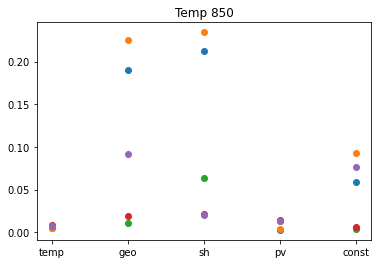

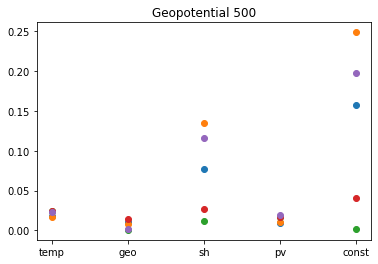

In [31]:
import pylab as plt
for i in range(5):
    plt.scatter(['temp', 'geo', 'sh', 'pv', 'const'],abs(ensemble_model.trainable_variables[0].numpy()[2*i]))
plt.title('Temp 850')
plt.show()    

for i in range(5):   
    plt.scatter(['temp', 'geo', 'sh', 'pv', 'const'], abs(ensemble_model.trainable_variables[0].numpy()[2*i + 1]))
plt.title('Geopotential 500')
plt.show()

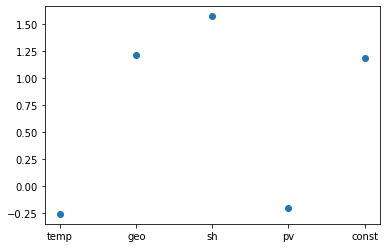

In [32]:
plt.scatter(['temp', 'geo', 'sh', 'pv', 'const'], ensemble_model.trainable_variables[1].numpy())